In [27]:
import os
import random
import yaml
import torch
import wandb
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage, Resize, Compose, Lambda

os.chdir("../")

from module.vae import AutoEncoder
from module.data import COCODataset

### Download Artifact from Wandb

In [1]:
run = wandb.init()

artifact = run.use_artifact('deepakdhull80/auto-encoder-project/auto-encoder:v45', type='model')
artifact_dir = artifact.download()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /Users/deepak.dhull/.netrc


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Downloading large artifact auto-encoder:v45, 505.00MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:5:11.8


### Initialize Model

In [5]:
state_dict = torch.load(f"nb/artifacts/auto-encoder:v45/model.pt", map_location="cpu")

In [6]:
cfg = yaml.safe_load(open("config/vae.yaml", "r"))
cfg['data']['data_prefix_path'] = '/Users/deepak.dhull/practice/data/val2017'

In [7]:
model = AutoEncoder(cfg)
model.load_state_dict(state_dict)
model = model.eval()

In [34]:
IMG_SIZE = 64
transform = Compose([Lambda(lambda batch: torch.clamp_(batch * 0.5 + 0.5, min=0, max=1)), Resize((IMG_SIZE, IMG_SIZE), antialias=True), ToPILImage()])

In [44]:
def plot_images(img: list, title: str = "Nothing", figsize=(25,25)):
    print(f"{title} Images")
    _, axs = plt.subplots(1, len(img), figsize=figsize)
    axs = axs.flatten()
    for i, ax in zip(img, axs):
        ax.imshow(i)
        ax.axis('off')
    plt.show()

### Generate Image for random Latent Space

In [41]:
inp = torch.randn(4, 1024)

with torch.no_grad():
    inp_p = model.decoder(inp)
    print(inp_p.shape)

inp_p = torch.clamp_(inp_p  * 0.5 + 0.5, min=0, max=1)

print(inp_p.min() , inp_p.max())


torch.Size([4, 3, 64, 64])
tensor(0.) tensor(1.)


In [42]:
imgs = []
for i in range(4):
    imgs.append(np.array(transform(inp_p[i])))

Random Generated Images


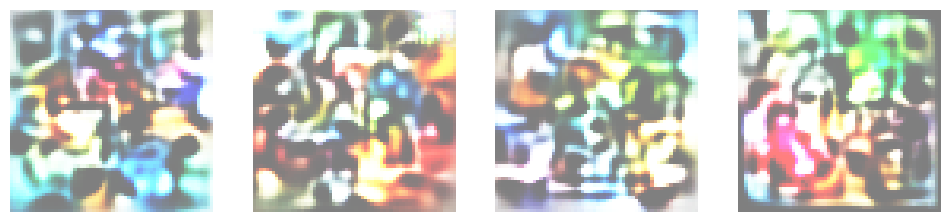

In [45]:
plot_images(imgs, "Random Generated", figsize=(12, 12))

### Generate Back ground images

In [11]:
img_li = os.listdir(cfg['data']['data_prefix_path'])
print(len(img_li))
sample_img_li = random.sample(img_li, 8)

In [26]:
ds = COCODataset(cfg, sample_img_li, disable_tansforms=False)
dl = torch.utils.data.DataLoader(ds, batch_size=8)
batch = next(iter(dl))

In [31]:
with torch.no_grad():
    out = model(batch)

In [35]:
gt_imgs, p_imgs = [], []
for i in range(out.shape[0]):
    gt_imgs.append(np.array(transform(batch[i])))
    p_imgs.append(np.array(transform(out[i])))

Ground Truth Images


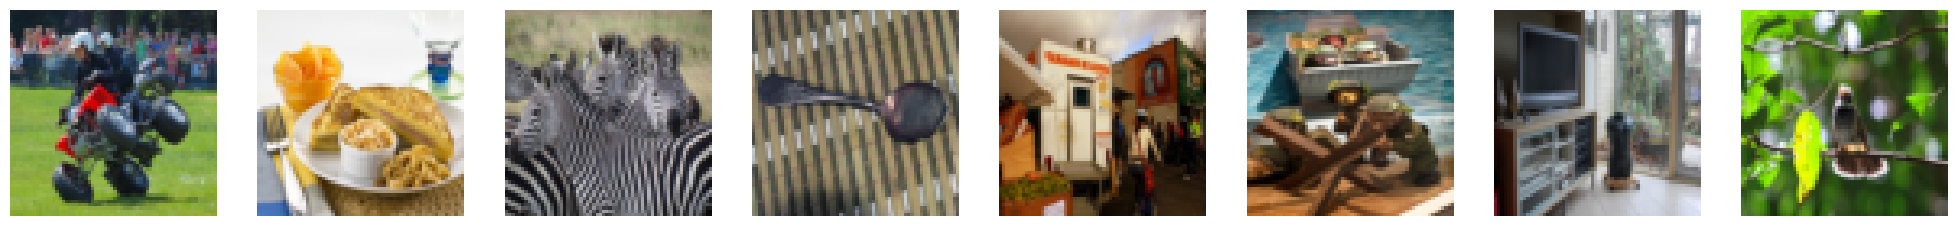

Predicted Images


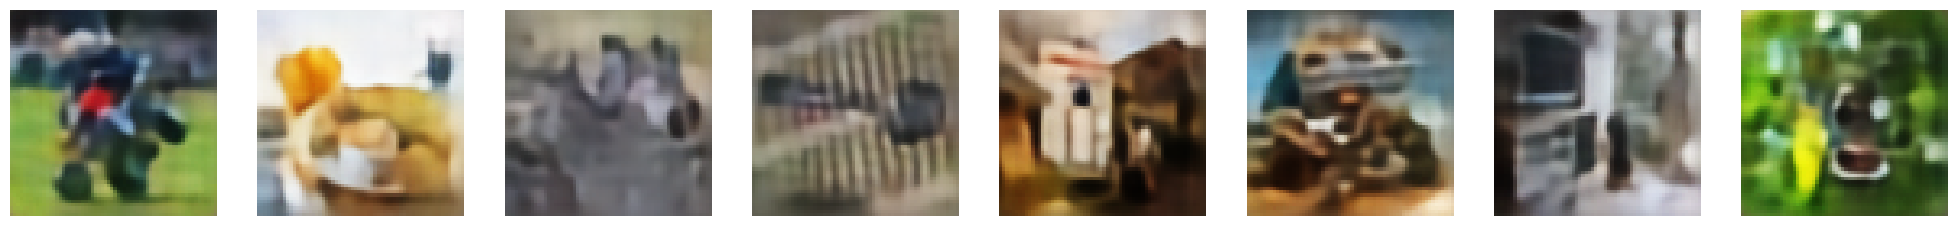

In [40]:
plot_images(gt_imgs, "Ground Truth")
plot_images(p_imgs, "Predicted")